In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from torch.cuda.amp import autocast, GradScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print("GPU 不可用，将在 CPU 上运行")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.cuda.empty_cache()  # 释放显存

cuda


In [48]:
#input_size, hidden_size,num_layers,dropout, num_factors, num_stocks,preday
#特征数，隐藏层神经元个数，隐藏层数，丢弃率，输出因子个数，股票个数，预测天数
#因子正交提取
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks,preday):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        self.preday=preday
        
        # 定义LSTM层
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()  #batch,时间步，股票数，特征数
        #print(x.shape)
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        #print(x.shape)
        # LSTM层
        lstm_out, _ = self.lstm(x)
        #print('lstmout',lstm_out.shape)
        # 最后10个时间步的输出
        lstm_out = lstm_out[:, -self.preday:, :]
        #print('最后时间步',lstm_out.shape)
        # 全连接层
        fc_out = self.fc(lstm_out)
        #print('全连接层',fc_out.shape)
        # 批标准化层
        fc_out=fc_out.view(batch_size*self.num_stocks*self.preday,self.num_factors)
        factor_output = self.bn(fc_out)
        #print('标准化层',factor_output.shape)
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks,self.preday, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=3)
        #print(c.shape)
        return factor_output
# model = MyModel(6, 64, 1,0,5, 400,1)
# x=torch.rand(4,60,400,6)
# y=model(x)

In [7]:

df20=pd.read_feather('/data/disk4/output_stocks/jmchen/factors/ML/combine20.feather')
df21=pd.read_feather('/data/disk4/output_stocks/jmchen/factors/ML/combine21.feather')
df=pd.concat([df20,df21],join='inner',axis=0)
df=df.drop('level_0',axis=1)
index_counts = df['index'].value_counts()
index_counts=index_counts[index_counts==index_counts.max()]  #选有数据的股票
print(index_counts)
dfx=df[df['index'].isin(index_counts.index)]
dfx=dfx.fillna(0)
ds=dfx.groupby('tradingday')
dfx

index
000001    486
300713    486
603358    486
300705    486
300706    486
         ... 
002614    486
002615    486
002616    486
002617    486
601900    486
Name: count, Length: 3002, dtype: int64


,index,20211217_10_rank,20211217_12_rank,20211217_1_abs,20211217_1_abs_regwin=1_rank_abs,20211217_1_abs_regwin=20_rank_abs,20211217_1_abs_regwin=40_rank_abs,20211217_1_abs_regwin=5_rank_abs,20211217_1_ori_regwin=10_abs,20211217_1_ori_regwin=10_rank_abs,...,vcv_all,vov_all,vov_peak_all,vov_range_all,vov_vol_peak_all,vr_all,buy_approx_uniform_all,extra_vol_all,tradingday,ret
0,000001,0.945312,1.848633,-0.225586,0.073425,0.003994,0.008438,0.058746,-0.228516,0.269775,...,0.557617,-0.850098,-0.358154,0.188110,-0.769043,-0.584473,-0.103760,-0.082031,2020-01-02,-0.071106
1,000002,0.637207,1.668945,0.940918,0.655762,0.179077,0.485352,0.658691,0.932617,1.614258,...,0.129272,0.459473,0.269775,-0.807129,-2.005859,-0.986328,-0.577637,0.001735,2020-01-02,-0.077515
2,000004,1.329102,-0.024048,0.238892,-1.000977,-0.659180,0.000000,-0.894531,0.211426,1.224609,...,0.164917,-0.422119,0.270508,-1.373047,-0.344482,0.607910,-0.786621,-1.340820,2020-01-02,-0.013062
4,000006,1.375000,0.661621,-0.806641,-0.352051,-0.384277,-0.224487,-0.462402,-0.757324,-0.881836,...,0.890137,0.694824,0.903320,0.157471,0.865723,0.989258,0.450195,0.711426,2020-01-02,-0.006252
6,000008,0.844727,1.416992,0.503418,-0.085815,-0.513672,-0.316406,-0.130737,0.216919,-0.324951,...,0.502441,0.331787,-0.330811,0.138184,0.869141,-1.795898,1.141602,0.119995,2020-01-02,-0.010834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012481,688366,0.158325,-0.744629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.052765,-0.539551,-0.559082,0.632324,-0.218628,0.696289,0.652344,-0.819336,2021-12-31,-0.034393
1012484,688369,0.492920,-1.183594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.159302,-0.241089,-0.907715,0.685059,0.418457,0.534180,0.072693,-0.563965,2021-12-31,0.137329
1012491,688388,-0.901367,-1.431641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.119019,0.141968,0.171143,-0.541992,-0.653809,0.902832,-0.171753,-0.034088,2021-12-31,-0.038879
1012492,688389,0.854980,-0.926270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.027344,0.790039,-0.075073,1.109375,1.058594,-0.277588,0.146729,0.778320,2021-12-31,-0.037354


In [ ]:
days=index_counts.max()
num_stocks=len(index_counts)
num_features=4370
X = torch.zeros((days, num_stocks, num_features))
Y = torch.zeros((days, num_stocks))

i=0
day_list=[] #标记测试集日期，用于回测
code_list=[]
for day,df in ds:
    print(day,i)
    if i==0:
        code_list=df['index'].to_list()
    df=df.set_index('index')
    x= df.drop(columns=['tradingday','ret'])
    X[i]=torch.Tensor(x.values)
    y=df['ret']
    Y[i]=torch.Tensor(y.values)
    if i>=400:
        day_list.append(day)
    i+=1
X=X.unsqueeze(1)  #增加时间维度
Y=Y.unsqueeze(1)

X_train=X[:400]
X_test=X[400:]
Y_train=Y[:400]
Y_test=Y[400:]

In [11]:
#class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_factors, num_stocks):
        super(MyModel, self).__init__()

        self.num_stocks = num_stocks
        
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, num_factors)
        
        return factor_output

In [30]:
#因子GRU正交提取
class MyModelG(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks):
        super(MyModelG, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        
        # 定义LSTM层
        self.GRU = nn.GRU(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # GRU
        lstm_out, _ = self.GRU(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=2)
        
        return factor_output

In [6]:
#多因子预测
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        
        # 定义LSTM层
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=2)
        
        return factor_output

In [9]:
#预测未来10日
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks,preday):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        self.preday=preday
        
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        # LSTM层
        lstm_out, _ = self.lstm(x)
        # 最后10个时间步的输出
        lstm_out = lstm_out[:, -self.preday:, :]
        # 全连接层
        fc_out = self.fc(lstm_out)
        # 批标准化层
        fc_out=fc_out.view(batch_size*self.num_stocks*self.preday,self.num_factors)
        factor_output = self.bn(fc_out)
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks,self.preday, self.num_factors)
    
        c = factor_output.mean(dim=3)

        return factor_output

In [30]:
batch_size = 10
stocks = 5

y = torch.rand(batch_size, stocks)
c = torch.rand(batch_size, stocks)

# 将 Torch 张量转换为 NumPy 数组，以便使用 SciPy 函数
y_numpy = y.numpy()
c_numpy = c.numpy()

# 初始化一个存储所有样本的相关系数的列表
all_corr = []

# 计算每个样本的斯皮尔曼相关系数，并将结果添加到列表中
for i in range(batch_size):
    spearman_corr, _ = spearmanr(y_numpy[i], c_numpy[i])
    all_corr.append(spearman_corr)
# 计算每个批次的平均斯皮尔曼相关系数
batch_average_corr = np.mean(all_corr)

print(batch_average_corr)
# 假设你有一个形状为 (batch_size, stocks, 64) 的张量 tensor
x=torch.rand(4,400,64)
# 初始化一个空的DataFrame
df_list = []
# 按照 a 遍历Tensor并将每个二维数组转换为DataFrame的一行
for i in range(x.shape[0]):
    # 获取当前二维数组
    current_array = x[i].numpy()
    
    # 将二维数组转换为DataFrame的一行，并添加到列表中
    current_df = pd.DataFrame(current_array)
    df_list.append(current_df)

# 使用 concat 函数将所有DataFrame连接成一个
df = pd.concat(df_list, ignore_index=True)
cor=df.corr()
cor=cor*cor
cor=cor.replace(1,0)
penalty=cor.values.sum()/2

print(penalty)

0.11999999999999995


In [ ]:
x=0.5
eps=0.00001
n=1
y=x
last_y=x
while True:
    last_y=y
    y+=math.pow(-1,n)*math.pow(x,2n+1)/(n+2)*math.factorial(n)
    if abs(y-last_y)<eps:
        print(y)
        break

In [69]:

x=X_train[0:1]
label=Y_train[0:1]
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)
# 加载保存的模型参数
model.load_state_dict(torch.load('/data/disk4/output_stocks/jmchen/factors/ML/lstm_zj_model/model'))
y=model(x)
print(y.shape)
c = y.mean(dim=3)
print(c.shape)
custom_loss_new(label, y,1)
pen=[]
for i in range(y.shape[0]): #batch内循环
        penalty=[]
        tt= y[i].transpose(0, 1)
        print(tt.shape)
        for j in range(tt.shape[0]): #天数内循环
            print(tt[j].shape)
            correlation_matrix = torch.corrcoef(tt[j].T)
  
            # 将对角线元素设置为零，即将每列与自身的相关系数剔除
            # for i in range(len(correlation_matrix)):
            #     correlation_matrix[i, i] = 0
            # 计算相关系数矩阵的frobenius范数
            frobenius_norm = torch.norm(correlation_matrix, p='fro')
            print(frobenius_norm)
            zsum = torch.sum(correlation_matrix**2)
            penalty.append(zsum)
            break
        
    
    

torch.Size([1, 3002, 1, 300])
torch.Size([1, 3002, 1])
tensor(0.0827, grad_fn=<MeanBackward0>)
tensor(1155.4189, grad_fn=<MeanBackward0>)
torch.Size([1, 3002, 300])
torch.Size([3002, 300])
tensor(38.1499, grad_fn=<LinalgVectorNormBackward0>)


In [71]:
def custom_loss_new(y, factor_output,k):
    c = factor_output.mean(dim=3)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        ct=c[i].T #stocks*preday
        cin=[]
        for j in range(c.shape[2]):
            mean_c = torch.mean(ct[j])
            mean_y = torch.mean(y[i][j])
            
            # Calculate the numerator and denominators for Pearson correlation
            numerator = torch.sum((ct[j] - mean_c) * (y[i][j] - mean_y))
            denominator_c = torch.sqrt(torch.sum((ct[j] - mean_c)**2))
            denominator_y = torch.sqrt(torch.sum((y[i][j] - mean_y)**2))
            
            # Calculate the Pearson correlation coefficient
            pearson_corr = numerator / (denominator_c * denominator_y)
            cin.append(pearson_corr)
        corr.append(torch.stack(cin).mean())
    corr=torch.stack(corr).mean()
    print(corr)
    pen=[]
    for i in range(factor_output.shape[0]): #batch内循环
        penalty=[]
        tt= factor_output[i].transpose(0, 1)
        for j in range(tt.shape[0]): #天数内循环
            correlation_matrix = torch.corrcoef(tt[j].T)
            # 计算相关系数矩阵的frobenius范数
            frobenius_norm = torch.norm(correlation_matrix, p='fro')
            # 将对角线元素设置为零，即将每列与自身的相关系数剔除
            # for i in range(len(correlation_matrix)):
            #     correlation_matrix[i, i] = 0
            # # 计算相关系数的平方和
            # zsum = torch.sum(correlation_matrix**2)
            penalty.append(frobenius_norm)
        pen.append(torch.stack(penalty).mean())
    pen=torch.stack(pen).mean()
    print(pen)
    loss=-corr+k*pen
    return loss

In [13]:
torch.cuda.empty_cache() 

In [74]:
# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks
num_features
T = 1  #时间步
num_epochs = 100
batch_size = 8

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_layers=1
dropout=0
num_factors = 300  #60个等权输出-天数？
preday=1
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)
# model = DataParallel(model)
model.to(device)  # 将模型移动到GPU


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=1)
count=0
# 训练模型
loss_history = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-batch_size, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 计算损失函数
        loss = custom_loss_new(labels, outputs,k=10)
            
        #print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} - Learning Rate: {current_lr}")

    #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=5:
                print('不收敛')
                break
    last=loss.item()/num_stocks


tensor(-0.0048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(44.5776, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(74.2258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(56.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0332, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(51.3504, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(47.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(45.4317, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(44.2843, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(43.3940, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(42.7035, de

In [7]:
def custom_loss(y, factor_output):
    c = factor_output.mean(dim=2)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        # # 计算秩次差值
        # rank_X = torch.argsort(c[i].reshape(-1))
        # rank_Y = torch.argsort(y[i].reshape(-1))
        # differences = rank_X - rank_Y
        # # 计算斯皮尔曼秩相关系数
        # n = len(c[i])
        # spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
        # corr.append(spearman_corr)
        mean_c = torch.mean(c[i])
        mean_y = torch.mean(y[i])
        
        # Calculate the numerator and denominators for Pearson correlation
        numerator = torch.sum((c[i] - mean_c) * (y[i] - mean_y))
        denominator_c = torch.sqrt(torch.sum((c[i] - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((y[i] - mean_y)**2))
        
        # Calculate the Pearson correlation coefficient
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr.append(pearson_corr)
    corr=torch.stack(corr).mean()
    penalty=[]
    for i in range(factor_output.shape[0]): #batch内循环
        correlation_matrix = torch.corrcoef(factor_output[i].T)
        # 将对角线元素设置为零，即将每列与自身的相关系数剔除
        for i in range(factor_output.shape[2]):
            correlation_matrix[i, i] = 0
        # 计算相关系数的平方和
        zsum = torch.sum(correlation_matrix**2)
        penalty.append(zsum)
    penalty=torch.stack(penalty).mean()
    loss=-corr+penalty
    return loss

In [ ]:

#def custom_loss(y, factor_output):
    # 计算c与标签之间的相关系数的负值
    c = factor_output.mean(dim=2)
    
    # 将 c 和 y 转移到 CPU 上（如果尚未在 CPU 上）
    c = c.cpu()
    y = y.cpu()
    
    # 将 factor_output 转移到 CPU 上（如果尚未在 CPU 上）
    factor_output = factor_output.cpu()
    
    # 将 Torch 张量转换为 NumPy 数组，以便使用 SciPy 函数
    y_numpy = y.detach().numpy()
    c_numpy = c.detach().numpy()
    
    all_corr = []
    
    # 计算每个样本的斯皮尔曼相关系数，并将结果添加到列表中
    for i in range(c.shape[0]):
        spearman_corr, _ = spearmanr(y_numpy[i], c_numpy[i])
        all_corr.append(spearman_corr)
    
    # 计算相关系数损失
    loss = -torch.mean(torch.tensor(all_corr, dtype=torch.float32))
  
    # 初始化一个空的 DataFrame 列表
    df_list = []
    
    # 按照 a 遍历 Tensor 并将每个二维数组转换为 DataFrame 的一行
    for i in range(factor_output.shape[0]):
        # 获取当前二维数组
        current_array = factor_output[i].detach().numpy()
        
        # 将二维数组转换为 DataFrame 的一行，并添加到列表中
        current_df = pd.DataFrame(current_array)
        df_list.append(current_df)

    # 使用 concat 函数将所有 DataFrame 连接成一个
    df = pd.concat(df_list, ignore_index=True)
    cor = df.corr()
    cor = cor * cor
    cor = cor.replace(1, 0)
    
    # 计算惩罚项损失
    penalty = torch.tensor(cor.values.sum() / 2, dtype=torch.float32)
    
    # 最终的损失函数为两个损失项之和
    total_loss = loss + penalty
    total_loss.requires_grad_(True)
    return total_loss

In [7]:


#def custom_loss(y, factor_output):
    # 计算c与标签之间的相关系数的负值
    c = factor_output.mean(dim=2)
    
    # 将 c 和 y 转移到 CPU 上（如果尚未在 CPU 上）
    c = c.cpu()
    y = y.cpu()
    
    # 将 factor_output 转移到 CPU 上（如果尚未在 CPU 上）
    factor_output = factor_output.cpu()
    
    # 将 Torch 张量转换为 NumPy 数组，以便使用 SciPy 函数
    y_numpy = y.detach().numpy()
    c_numpy = c.detach().numpy()
    
    all_corr = []
    
    # 计算每个样本的斯皮尔曼相关系数，并将结果添加到列表中
    for i in range(c.shape[0]):
        spearman_corr, _ = spearmanr(y_numpy[i], c_numpy[i])
        all_corr.append(spearman_corr)
    
    # 计算相关系数损失
    loss = -torch.mean(torch.tensor(all_corr, dtype=torch.float32))
  
    # 初始化一个空的 DataFrame 列表
    df_list = []
    
    # 按照 a 遍历 Tensor 并将每个二维数组转换为 DataFrame 的一行
    for i in range(factor_output.shape[0]):
        # 获取当前二维数组
        current_array = factor_output[i].detach().numpy()
        
        # 将二维数组转换为 DataFrame 的一行，并添加到列表中
        current_df = pd.DataFrame(current_array)
        df_list.append(current_df)

    # 使用 concat 函数将所有 DataFrame 连接成一个
    df = pd.concat(df_list, ignore_index=True)
    cor = df.corr()
    cor = cor * cor
    cor = cor.replace(1, 0)
    
    # 计算惩罚项损失
    penalty = torch.tensor(cor.values.sum() / 2, dtype=torch.float32)
    
    # 最终的损失函数为两个损失项之和
    total_loss = loss + penalty
    total_loss.requires_grad_(True)
    return total_loss

In [27]:
torch.cuda.empty_cache()  # 释放显存
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()


In [ ]:

# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks = 3726
num_features = 6
T = 60  #时间步
num_epochs = 20
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_factors = 60  #60个等权输出-天数？

model = MyModel(input_size, hidden_size, num_factors, num_stocks)

# model = DataParallel(model)
model.to(device)  # 将模型移动到GPU


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=1)

# 训练模型
loss_history = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-4, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 计算损失函数
        loss = custom_loss(labels, outputs)
            
        print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} - Learning Rate: {current_lr}")


In [55]:
torch.cuda.empty_cache()

In [ ]:
# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks 
num_features 
T =   #时间步
num_epochs = 30
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_layers=3
dropout=0.1
num_factors = 60  #60个等权输出-天数？

model = MyModelG(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks)
best_spearman_corr=-1
# model = DataParallel(model)
model.to(device)  # 将模型移动到GPU


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)
count=0
# 训练模型
loss_history = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-4, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 计算损失函数
        loss = custom_loss(labels, outputs)
            
        print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} - Learning Rate: {current_lr}")

    #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=3:
                print('不收敛')
                break
    last=loss.item()/num_stocks
    # 在验证集上计算斯皮尔曼相关系数
#     with torch.no_grad():
#         torch.cuda.empty_cache() 
#         c = []
#         for i in range(0, X_val.size(0)-4, batch_size):
#             input_sample = X_val[i:i+batch_size].to(device)
#             label_sample = Y_val[i:i+batch_size].to(device)
#             # input_sample = X_val  # 获取单个样本并添加批次维度
#             # label_sample = Y_val
#             # 使用模型进行推理并获取单个样本的预测输出（c值）
#             factors = model(input_sample)
#             c_value=factors.mean(dim=2)
#             print(c_value.shape)
#             corr2=[]
#             for i in range(c_value.shape[0]): 
#                 rank_X = torch.argsort(c_value[i].reshape(-1))
#                 rank_Y = torch.argsort(label_sample[i].reshape(-1))
#                 differences = rank_X - rank_Y
#                 # 计算斯皮尔曼秩相关系数
#                 n = len(c_value[i])
#                 spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
#                 print(spearman_corr)
#                 corr2.append(spearman_corr)
#             # 更新最佳斯皮尔曼相关系数和模型权重
#             corr2=sum(corr2)/len(corr2)
#             c.append(corr2)
#         c=sum(c)/len(c)
#         if c > best_spearman_corr:
#             best_spearman_corr = c
#             best_model_weights = model.state_dict()
#         print(best_spearman_corr)
#     # 如果斯皮尔曼相关系数达到了某个停止条件，可以提前停止训练
#     if best_spearman_corr >= 0.2:
#         print(f"Training stopped early at Epoch {epoch + 1} because of achieving the desired Spearman correlation.")
#         break

# # 使用最佳模型权重
# model.load_state_dict(best_model_weights)

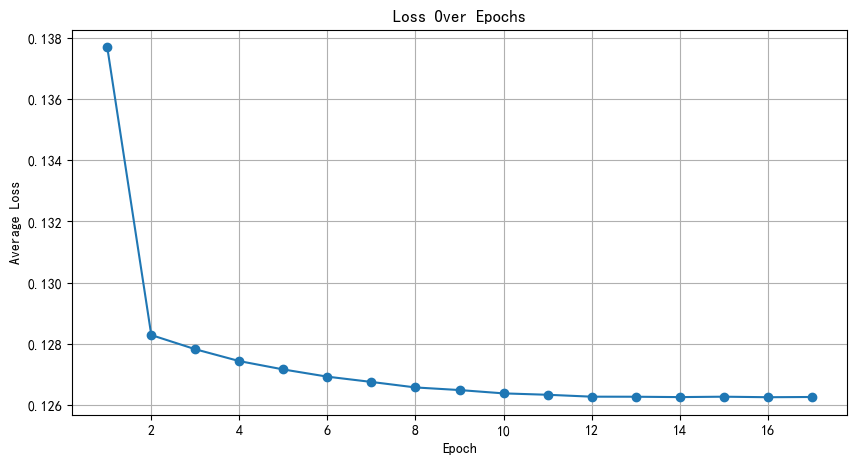

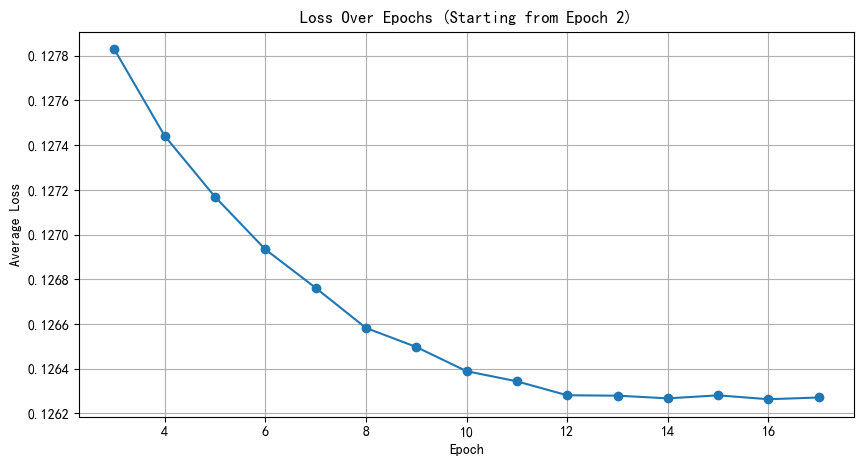

In [75]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, marker='o', linestyle='-')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

plot_loss(loss_history)
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(3, len(loss_history) + 1)  # 从第二轮开始绘制，所以范围从2开始
    plt.plot(epochs, loss_history[2:], marker='o', linestyle='-')  # 从第二轮开始绘制，所以从索引1开始
    plt.title('Loss Over Epochs (Starting from Epoch 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

# 调用修改后的函数以绘制损失图
plot_loss(loss_history)

In [36]:
# 保存模型参数
torch.save(model.state_dict(), '/data/disk4/output_stocks/jmchen/factors/ML/lstm_zj_model/model')


In [ ]:
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)
# 加载保存的模型参数
model.load_state_dict(torch.load('/data/disk4/output_stocks/jmchen/factors/ML/lstm_zj_model/model'))
with torch.no_grad():
    factors=model(X_test)
    print(factors)

In [37]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

#input_size, hidden_size,num_layers,dropout, num_factors, num_stocks
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)
# 加载保存的模型参数
model.load_state_dict(torch.load('/data/disk4/output_stocks/jmchen/factors/ML/lstm_zj_model/model'))

# 设置模型为评估模式
model.eval()
ic_values = []

with torch.no_grad():
    input_sample = X_test  # 获取单个样本并添加批次维度
    label_sample = Y_test
    # 使用模型进行推理并获取单个样本的预测输出（c值）
    factors = model(input_sample)
    c_value=factors.mean(dim=3)
    print(c_value.shape)
    print(label_sample.shape)
    c1=[]
    c2=[]
    for i in range(c_value.shape[0]): 
        cv=c_value[i].T
        corr1=[]
        corr2=[]
        for j in range(cv.shape[0]):
            # 创建遮罩以识别c_value和Y_test中的非NaN值
            mask_c = ~torch.isnan(cv[j])
            mask_y = ~torch.isnan(label_sample[i][j])
            
            # 组合这些遮罩以获取c_value和Y_test的共同遮罩
            mask = mask_c & mask_y
            
            # 将遮罩应用于张量
            c_value_filtered = cv[j][mask]
            Y_test_filtered = label_sample[i][j][mask]

        
            # 计算每个输入的均值
            mean_c = torch.mean(c_value_filtered)
            mean_y = torch.mean(Y_test_filtered)
            # print(mean_c,mean_y)
            # 计算皮尔逊相关系数的分子和分母
            numerator = torch.sum((c_value_filtered - mean_c) * (Y_test_filtered - mean_y))
            # print(numerator)
            denominator_c = torch.sqrt(torch.sum((c_value_filtered - mean_c)**2))
            denominator_y = torch.sqrt(torch.sum((Y_test_filtered - mean_y)**2))

            # 计算皮尔逊相关系数
            pearson_corr = numerator / (denominator_c * denominator_y)
            corr1.append(pearson_corr.item())
            # 计算秩次差值
            rank_X = torch.argsort(cv[j].reshape(-1))
            rank_Y = torch.argsort(label_sample[i][j].reshape(-1))
            differences = rank_X - rank_Y
            # 计算斯皮尔曼秩相关系数
            n = len(c_value[i])
            spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
            corr2.append(spearman_corr)
        c1.append(np.mean(corr1))
        c2.append(np.mean(corr2))
    c1=np.mean(c1)
    c2=np.mean(c2)
    print('Pearson:',c1)
    print('Spearman:',c2)


torch.Size([86, 3002, 1])
torch.Size([86, 1, 3002])
Pearson: 0.025287959020758092
Spearman: 0.0013368801


In [43]:
# model_path='/data/disk4/output_stocks/jmchen/factors/ML/zj_model/model_num_factors_400_lr_0.01_batch_8_k_0.1.pt'
# model.load_state_dict(torch.load(model_path))
# # 设置模型为评估模式
# model.eval()

with torch.no_grad():
    input_sample = X_test  # 获取单个样本并添加批次维度
    label_sample = Y_test
    # 使用模型进行推理并获取单个样本的预测输出（c值）
    factors = model(input_sample)
    c_value=factors.squeeze(2).mean(dim=2)
    print(c_value.shape)
    print(label_sample.shape)

    
dff=pd.DataFrame(c_value.numpy())
dff.columns=code_list
dff.index=day_list
dff.to_csv('/data/disk4/output_stocks/jmchen/factors/ML/lstm_21.csv')

torch.Size([86, 3002])
torch.Size([86, 1, 3002])


加载回测环境
保存回测环境
清洗因子数据并匹配收益率
加载因子数据
计算不同期限的未来收益率
因子分组
env success
因子IC分析
            IC
2021  0.021076
因子分组表现
因子分组收益图
因子净值曲线
因子分布
因子覆盖度
因子多空表现
因子IC分析
            IC
2021  0.021076
合并为PDF
(960, 720) 2021_因子净值曲线.png
(579, 121) 因子IC分析.png
(960, 720) 因子净值曲线.png
(1000, 700) 因子分布.png
(640, 480) 因子分组净值-1.png
(640, 480) 因子分组净值-10.png
(640, 480) 因子分组净值-20.png
(640, 480) 因子分组净值-5.png
(1258, 551) 因子分组收益图.png
(1178, 272) 因子多空表现.png
(1161, 272) 因子表现-1.png
(1161, 272) 因子表现-10.png
(1161, 272) 因子表现-20.png
(1161, 272) 因子表现-5.png
(1000, 700) 因子覆盖度.png
(704, 528) 因子逐年IC.png


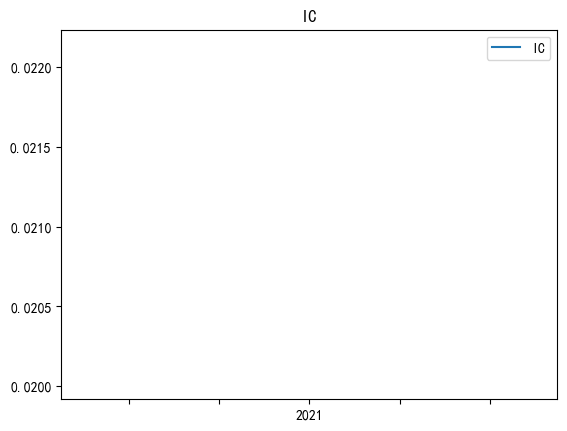

<Figure size 1000x200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

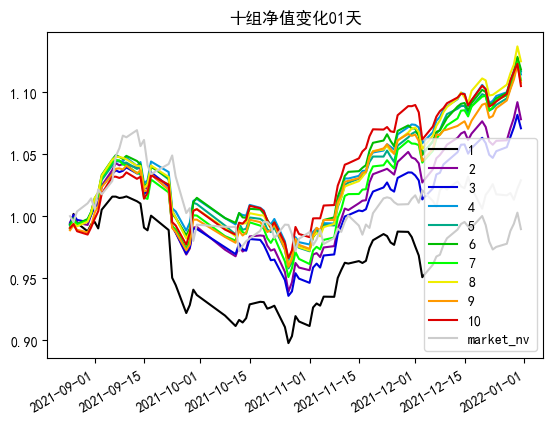

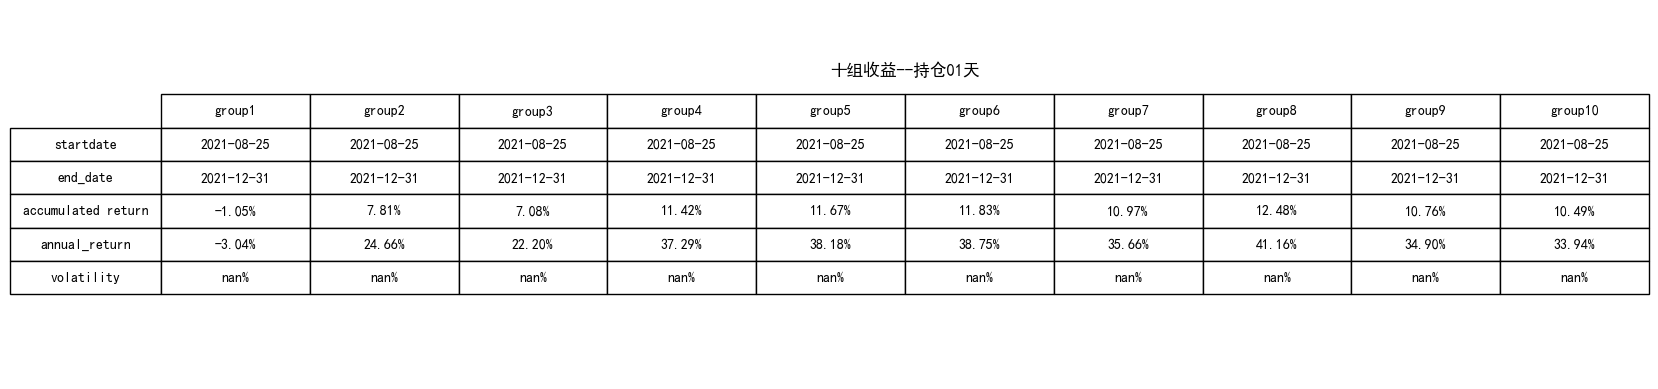

<Figure size 640x480 with 0 Axes>

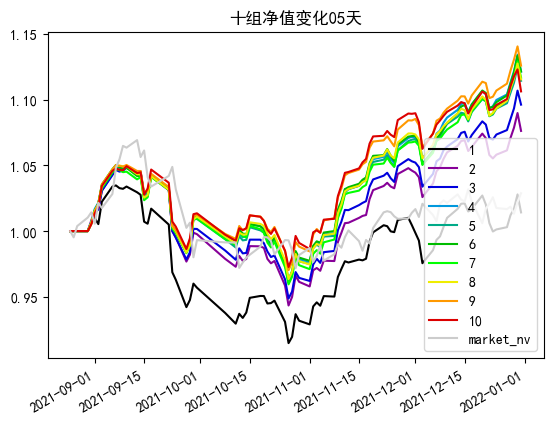

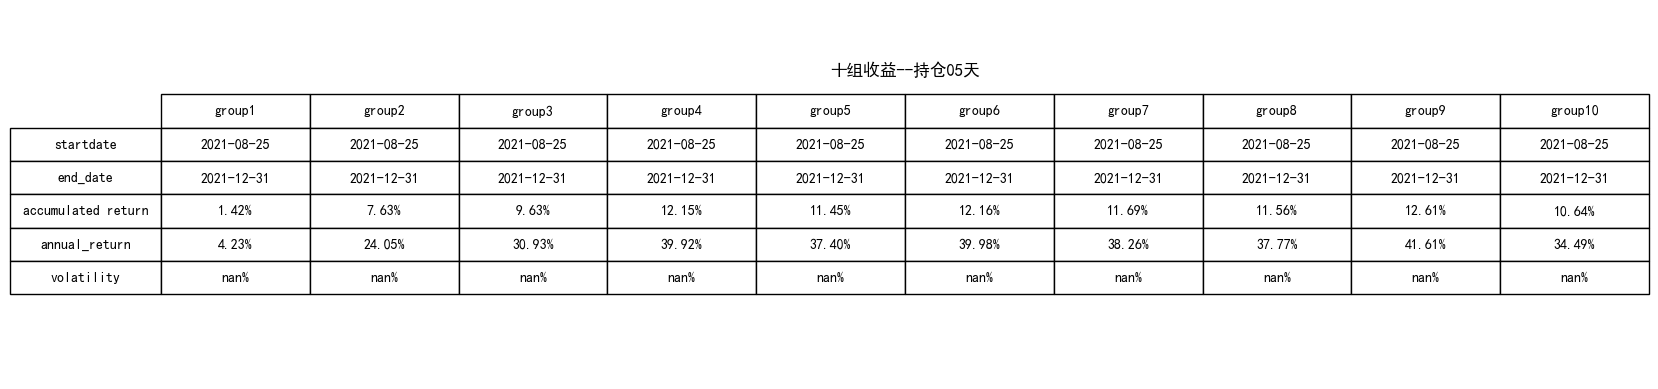

<Figure size 640x480 with 0 Axes>

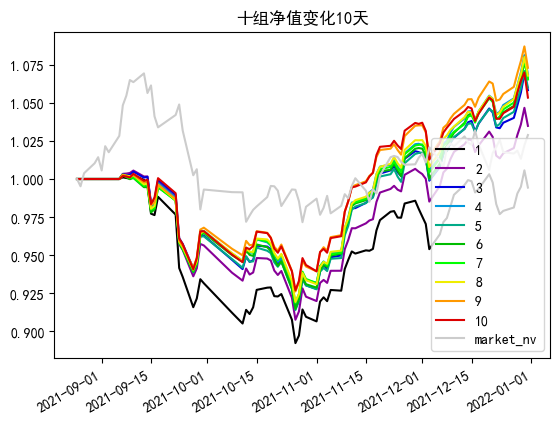

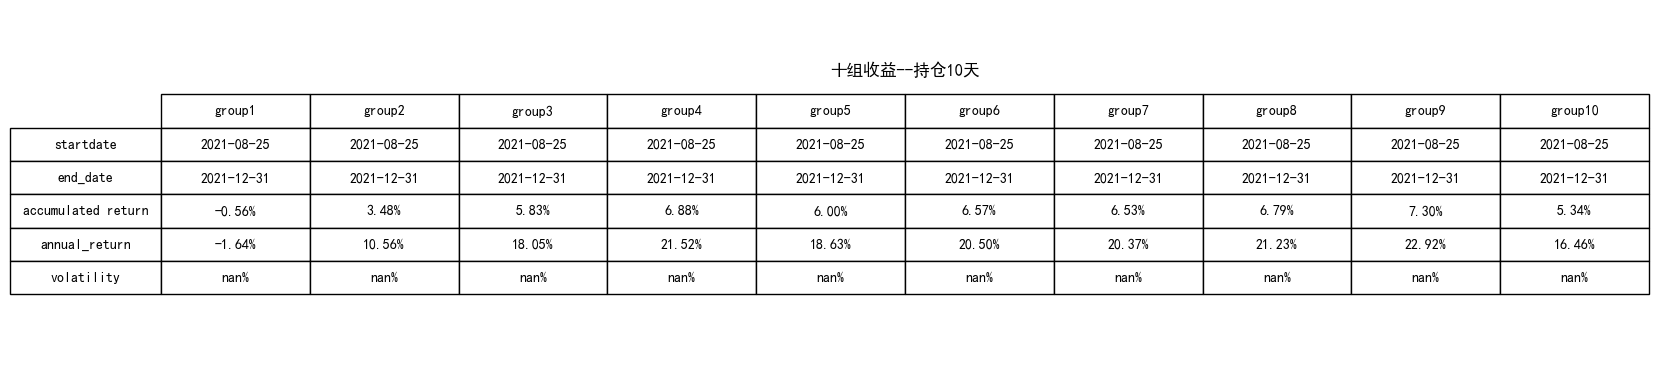

<Figure size 640x480 with 0 Axes>

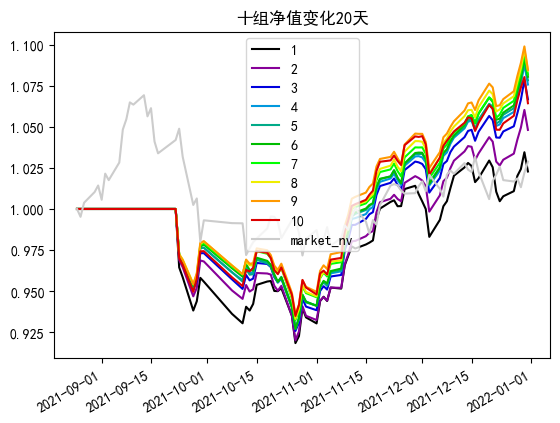

<Figure size 640x480 with 0 Axes>

<Figure size 1800x800 with 0 Axes>

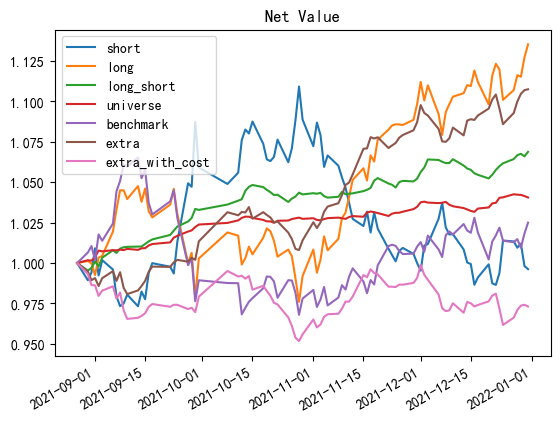

<Figure size 640x480 with 0 Axes>

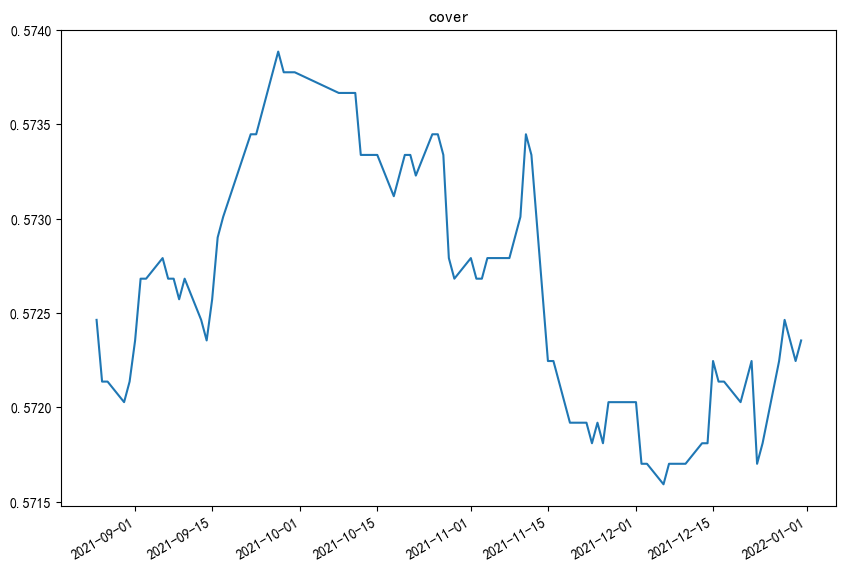

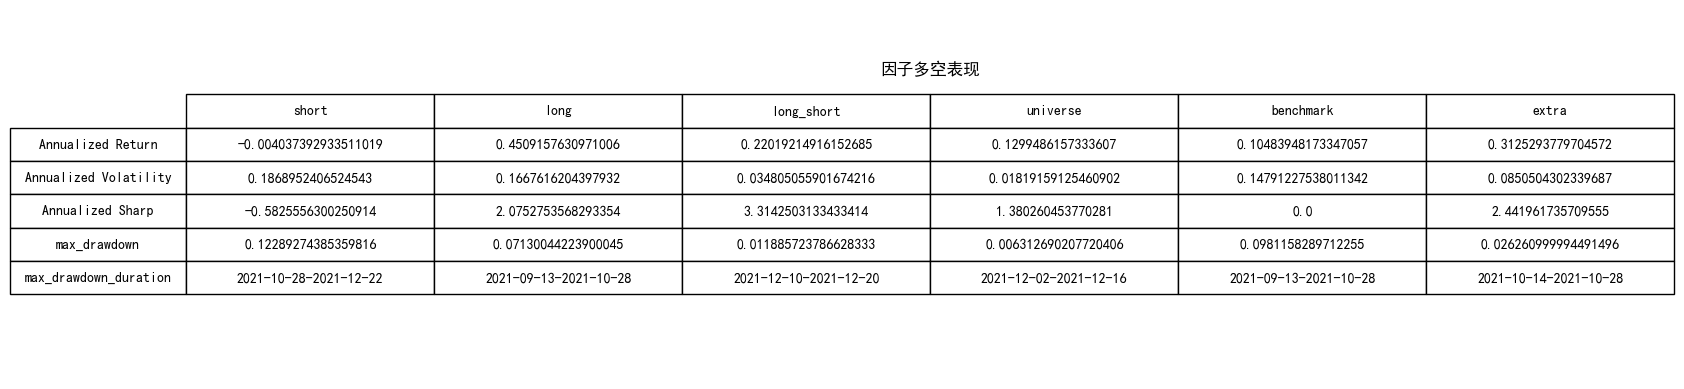

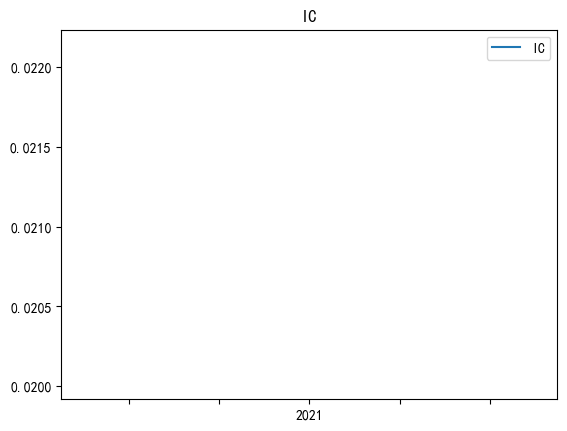

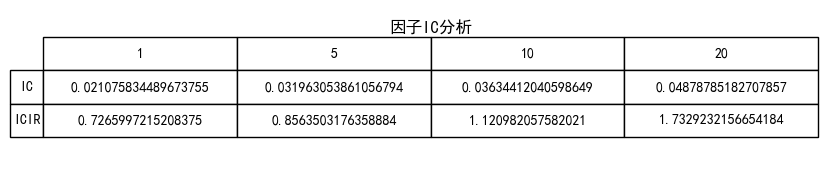

In [44]:
import sys
import seaborn as sns
sys.path.append("/data/disk4/output_stocks/jmchen/backtool")
from factor_backtest import *
factor_path = "/data/disk4/output_stocks/jmchen/factors/ML/lstm_21.csv"
factor_name = 'lstm_21'
result_path = "/data/disk4/output_stocks/jmchen/factors/ML/performance/"
env_path = "/data/disk4/output_stocks/jmchen/backtool/"
os.makedirs(result_path, exist_ok = True)
# factor = pd.read_feather(factor_path).set_index(['ds'])
factor = pd.read_csv(factor_path, index_col=0)
factor.index = pd.to_datetime(factor.index.astype('str'))
factor = 1 * factor.replace(np.inf, np.nan)
# factor = factor.rolling(window=20, min_periods=15).mean()
# factor = factor.loc['2016-01-01':'2022-01-01']
env = Environment(
                    factor_name = factor_name,
                    factor = factor,
                    holding_periods = [1,5,10,20], 
                    save_path = result_path, 
                    env_pkl_path = env_path,
                    method='load',
                    # if_neutral=['indes','size']
                    )
env.run_all()

funs = Functions(env)
funs.ic_calculating()
funs.run_all()
perform = Performance(result_path + factor_name)
perform.render()